# ML Analysis
Will attempt to do some sort of clustering.
## Set up Environment

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# vectorizing the book info column using TFidf Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn import tree

In [2]:
path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/")

In [3]:
os.listdir(path + 'processed')

['processed_books.csv']

## Pull in required data:

In [4]:
df = pd.read_csv(path + 'processed/processed_books.csv')

In [5]:
df.shape

(36196, 19)

In [6]:
df.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings,weighted_ratings_group,weighted_ratings_group_encoded
0,0399135782,kitchen god wife,amy tan,1991.0,putnam pub group,kitchen god wife by amy tan,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,malaysia,65,0,"(4, 24]",10.0,1,21.0,8.325719,"(8.0, 8.5]",3


### TF-IDF for Book Info:

In [7]:
tf = TfidfVectorizer(analyzer = "word", ngram_range=(1,2), min_df=0, stop_words='english')

In [8]:
tfidf_matrix = tf.fit(df['Book-Info'])

In [9]:
book_vector = tfidf_matrix.transform(df['Book-Info']).toarray()

In [10]:
df['Book-Vector'] = list(book_vector)

## Prepare model:

## Split into train and test set
also want to do cross validation to get mean of models

In [11]:
df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Book-Publisher', 'Book-Info', 'Book-Vector',
       'Year-Of-Publication-Group', 'Year-Of-Publication-Group-Encoded',
       'User-Country', 'User-Country-Encoded', 'Age-Group-Encoded',
       'Age-Group', 'average_rating', 'times_read', 'average_age',
       'weighted_ratings', 'weighted_ratings_group',
       'weighted_ratings_group_encoded'],
      dtype='object')

In [12]:
X = df[['Book-Info', 'User-Country-Encoded', 'Age-Group-Encoded', 'Year-Of-Publication-Group-Encoded']]
y = df['weighted_ratings_group_encoded']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [14]:
X_train.head(1)

,Book-Info,User-Country-Encoded,Age-Group-Encoded,Year-Of-Publication-Group-Encoded
17242,guardian by john saul,121,0,7


## Train Model

In [15]:
%%time
# Define text preprocessing (TF-IDF vectorization) and numeric preprocessing pipelines
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer = "word", ngram_range=(1,2), min_df=0, stop_words='english'))
])


# Define column transformer to apply different preprocessing to specific columns
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'Book-Info'),
    ('group', 'passthrough', ['Age-Group-Encoded', 'Year-Of-Publication-Group-Encoded']),
    ('country', 'passthrough', ['User-Country-Encoded'])
])

# Define the full pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

CPU times: user 5.9 s, sys: 167 ms, total: 6.06 s
Wall time: 6.4 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(min_df=0,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english'))]),
                                                  'Book-Info'),
                                                 ('group', 'passthrough',
                                                  ['Age-Group-Encoded',
                                                   'Year-Of-Publication-Group-Encoded']),
                                                 ('country', 'passthrough',
                                                  ['User-Country-Encoded'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [16]:
y_pred = pipeline.predict(X_test)

## Results

In [19]:
y_pred_train = pipeline.predict(X_train)

# Display classification report
print("Classification Report (Training Set):")
print(classification_report(y_train, y_pred_train))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix (Training Set):")
print(conf_matrix_train)

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1752
           1       0.95      0.99      0.97     10407
           2       0.97      0.96      0.97      6549
           3       1.00      0.95      0.97      9137
           4       1.00      0.92      0.96      1111

    accuracy                           0.97     28956
   macro avg       0.97      0.96      0.96     28956
weighted avg       0.97      0.97      0.97     28956

Confusion Matrix (Training Set):
[[ 1748     3     1     0     0]
 [   92 10308     1     6     0]
 [   23   221  6302     3     0]
 [   48   259   178  8652     0]
 [    2    36    22    34  1017]]


In [20]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix_train)

Accuracy: 0.33176795580110496
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.13      0.11      0.12       463
           1       0.39      0.43      0.41      2567
           2       0.23      0.21      0.22      1613
           3       0.38      0.37      0.37      2323
           4       0.23      0.23      0.23       274

    accuracy                           0.33      7240
   macro avg       0.27      0.27      0.27      7240
weighted avg       0.33      0.33      0.33      7240

Confusion Matrix (Test Set):
[[  49  214   84  108    8]
 [ 165 1095  572  699   36]
 [  79  663  344  485   42]
 [  77  788  482  851  125]
 [  11   58   33  109   63]]


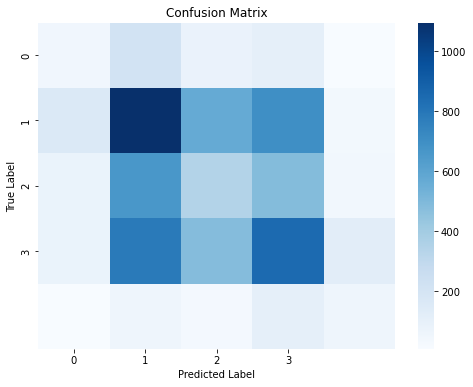

In [21]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, fmt='%d', cmap='Blues',
            xticklabels=['0', '1', '2', '3'],
            yticklabels=['0', '1', '2', '3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [22]:
cm

array([[  49,  214,   84,  108,    8],
       [ 165, 1095,  572,  699,   36],
       [  79,  663,  344,  485,   42],
       [  77,  788,  482,  851,  125],
       [  11,   58,   33,  109,   63]])

## Able to estimate popularity:

In [48]:
example_dict = {'Book-Info':'harry potter by jk rowling',
                          'User-Country-Encoded':65, 'Age-Group-Encoded':2,
                'Year-Of-Publication-Group-Encoded':7}
example_dict

{'Book-Info': 'harry potter by jk rowling',
 'User-Country-Encoded': 65,
 'Age-Group-Encoded': 2,
 'Year-Of-Publication-Group-Encoded': 7}

In [49]:
X_example = pd.DataFrame(example_dict, index = [0])

In [50]:
X_example

,Book-Info,User-Country-Encoded,Age-Group-Encoded,Year-Of-Publication-Group-Encoded
0,harry potter by jk rowling,65,2,7


In [51]:
pipeline.predict(X_example)

array([3])

In [107]:
df[['Year-Of-Publication-Group', 'Year-Of-Publication-Group-Encoded']].drop_duplicates()

,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded
0,"(1989, 1999]",7
45,"(1999, 2009]",8
169,"(1979, 1989]",6
1555,"(1959, 1969]",4
1568,"(1969, 1979]",5
5919,"(1949, 1959]",3
22190,"(1929, 1939]",1


In [108]:
df[['weighted_ratings_group', 'weighted_ratings_group_encoded']].drop_duplicates()

,weighted_ratings_group,weighted_ratings_group_encoded
0,"(8.0, 9.0]",3
1,"(7.5, 8.0]",2
14,"(6.0, 7.5]",1
46,"(0.0, 6.0]",0
195,"(9.0, 10.0]",4


In [47]:
df[['Age-Group', 'Age-Group-Encoded']].drop_duplicates()

,Age-Group,Age-Group-Encoded
0,"(4, 24]",0
1,"(24, 35]",1
2,"(50, 100]",3
5,"(35, 50]",2


In [48]:
df[['User-Country', 'User-Country-Encoded']].drop_duplicates()

,User-Country,User-Country-Encoded
0,malaysia,65
1,unknown,121
3,usa,124
7,australia,7
8,brazil,15
...,...,...
27076,urugua,122
30872,croatia,25
33013,u.s.a.,115
33266,tajikistan,107
